In [1]:
import sys
sys.path.insert(1, '../src/magpies/')
from magpies import *
from atmos import *
import numpy as np
from math import *
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
## Radius and mass of neutron star
Rns = 12  ## km
Mns = 1.4 ## M_solar
Tb = pow(10, 8.3648)  ## K
Bp = 1e14 ## G

## Instrument and exposure
eph = np.linspace (0.20, 3.00, 32) ## Nicer soft X-ray range
nphot = 1e5

g14c = g14 (Rns, Mns) ## computing the free fall acceleration
 
print ('g14 = ', g14c)

g14 =  1.6054273795798544


In [3]:
## Initialising the atmosphere
atm_iron_2003 = NS_atmosphere ('Potekhin_2003_iron', g14c, Tb, Bp)
atm_iron_2003.describe ()

Surface temperatures for magnetised envelope of NS
Following fit from Potekhin, Yakovlev, Chabrier & Gnedin (2003) for iron envelope
The Astrophysical Journal, Volume 594, Issue 1, pp. 404-418  2003ApJ...594..404P
Same fits are provided in Beznogov, Potekhin & Yakovlev (2021) for iron envelope
Physics Reports, Volume 919, p. 1-68 2021PhR...919....1B


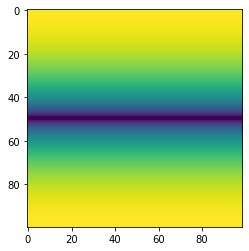

In [4]:
theta = np.linspace (0, pi, 100)  ## theta coordinates
phi   = np.linspace (0, 2*pi, 99) ## phi coordinates

theta1, phi1 = np.meshgrid (theta, phi)

Ts = atm_iron_2003.Ts (theta1) ## Surface temperatures

#for i in range (0, Ts.shape[0]):
#    for j in range (0, Ts.shape[1]):
#        Ts[i,j] = 1e6

plt.imshow(Ts.T)

In [5]:
L = compute_L(theta, phi, Rns, Ts)
Teff = compute_Teff(theta, phi, Rns, Ts)
print (L, log10(Teff))

4.6346150621714404e+33 6.163714563428665


In [6]:
Ts_uniform = np.full((Ts.shape[0], Ts.shape[1]), Teff)
Teff1 = compute_Teff(theta, phi, Rns, Ts_uniform)
L1 = compute_L(theta, phi, Rns, Ts_uniform)
print (L1, log10(Teff1))

4.6815141560776963e+33 6.164807731485772


In [7]:
sp, vis = get_redshifted_spectra_pole_photons(theta, phi, Ts, Rns, Mns, eph, nphot)

../src/magpies/magpies.py:186: RuntimeWarning: divide by zero encountered in log
  x = (1.0 - u)*y*(1.0 + u*u*y*y/112.0 - e/100.0*u*y*(np.log(1-y/2.0) + y/2))
../src/magpies/magpies.py:188: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(res)


In [8]:
res = fit_spectral_model_Cstat (Teff, Rns, Mns, sp, eph, nphot, L)
print (res)

[0.30069092702157296, 0.26102251499596485, 0.9862993363311362, 1.2867019293358486, 112.63086447463569, 7.03656576315319]


In [9]:
print (L)
print (compute_L_param ([0.1,0.01, 1, 1], Teff, Rns, Mns))
print (compute_L_param (res[0:4], Teff, Rns, Mns))

4.6346150621714404e+33
5.098076568388584e+32
4.6346851298733527e+33


In [10]:
print (res[0:4])

[0.30069092702157296, 0.26102251499596485, 0.9862993363311362, 1.2867019293358486]


In [11]:
print (Cstat_1BB ([0.615, 1.1289], Teff, Rns, Mns, sp, eph, nphot, L))

112.7420099565916


In [12]:
x1 = [0.7, 1.3]
res_1BB = minimize (Cstat_1BB, x1, method = 'Nelder-Mead',args=(Teff, Rns, Mns, sp, eph, nphot, L))
print (res_1BB)

 final_simplex: (array([[0.6155844 , 1.12892475],
       [0.61563126, 1.128916  ],
       [0.61568432, 1.12888293]]), array([112.63086447, 112.63088456, 112.63093806]))
           fun: 112.63086447463569
       message: 'Optimization terminated successfully.'
          nfev: 71
           nit: 36
        status: 0
       success: True
             x: array([0.6155844 , 1.12892475])


In [13]:
x2 = [0.2, 0.8, 1.6, 1.3]
res_2BB = minimize (Cstat_2BB, x2, method = 'Nelder-Mead',args=(Teff, Rns, Mns, sp, eph, nphot, L))
print (res_2BB)

 final_simplex: (array([[0.30069093, 0.26102251, 0.98629934, 1.28670193],
       [0.30069014, 0.26100806, 0.986275  , 1.28673449],
       [0.30068976, 0.26102896, 0.98623727, 1.28671842],
       [0.30068725, 0.26109745, 0.98624131, 1.2866414 ],
       [0.30068939, 0.26100991, 0.98623072, 1.28675667]]), array([7.03656576, 7.03656741, 7.03657198, 7.03662054, 7.03663964]))
           fun: 7.03656576315319
       message: 'Optimization terminated successfully.'
          nfev: 228
           nit: 128
        status: 0
       success: True
             x: array([0.30069093, 0.26102251, 0.98629934, 1.28670193])


4.6340557242979083e+33
4.6346851298733527e+33


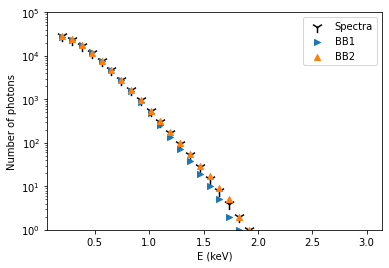

In [14]:
sp_BB1 = examine_spectral_fit_1BB_photons ([0.6155844 , 1.12892475], Teff, Rns, Mns, eph, nphot, L)
sp_BB2 = examine_spectral_fit_2BB_photons (res_2BB.x, Teff, Rns, Mns, eph, nphot, L)

print (compute_L_param ([0.6155844 , 1.12892475], Teff, Rns, Mns))
print (compute_L_param (res_2BB.x, Teff, Rns, Mns))

plt.scatter (eph, sp, label='Spectra', marker='1', color='black', s=128)
plt.scatter (eph, sp_BB1, label='BB1', marker='>')
plt.scatter (eph, sp_BB2, label='BB2', marker='^')
plt.yscale('log')
plt.ylim([1,1e5])
plt.ylabel('Number of photons')
plt.xlabel('E (keV)')
plt.legend()